In [1]:
#Importing Libraries
import numpy as np
import os
import pandas as pd
from numpy import array
import keras_self_attention
import seaborn as sns
import matplotlib.pyplot as plt
import re
import num2words
from tensorflow.keras import backend
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Lambda, Input, concatenate,BatchNormalization, Activation, Multiply
from keras.layers.embeddings import Embedding
from keras.layers import LSTM,Conv1D,MaxPooling1D, Bidirectional, GRU, RepeatVector, TimeDistributed
from keras.models import Model
from keras.activations import softmax
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from itertools import combinations
from keras_self_attention import SeqSelfAttention
from scipy.stats import entropy
import keras

%matplotlib inline

Using TensorFlow backend.


### 1. Import Files: 

In [2]:
local_path = r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/Raw/inquiry_lessons'
files_path = []
# r=root, d=directories, f = files
for r, d, f in os.walk(local_path):
    for file in f:
        if '.xlsx' in file:
            files_path.append(os.path.join(r, file))
            
n_files = len(files_path)
print('Number of Files: '+str(n_files))

Number of Files: 11


### 2. Preprocessing of Data 

In [3]:
dfs = []
for path in files_path:
    df = pd.read_excel(path)
    df = df[np.isfinite(df['Phase'])]
    df['Phase'] = df['Phase'].astype(int)-1
    df['Utterance'] = df['Utterance'].apply(lambda row: re.sub(r"(\d+)", lambda x: num2words.num2words(int(x.group(0))), row))
    df['Utterance'] = df['Utterance'].apply(lambda row: row.replace('?',' ?'))
    dfs.append(df)
docs_size = pd.Series([df.shape[0] for df in dfs])
dfs[0].head()

,StudentID,Student,time_start,time_end,Phase,Phase_start,Phase_end,Utterance
0,O2,NaN,NaN,NaN,0,1.0,NaN,Satunnaiskävely.
1,O1,NaN,NaN,NaN,0,NaN,NaN,[lukee tehtävänantoa]
2,O1,NaN,NaN,NaN,0,NaN,1.0,Voi voi. [käynnistää videon]
3,O1,NaN,NaN,NaN,0,1.0,NaN,"Missä se vaeltaa siellä ? Onks se, ei. Ei, se ..."
4,O2,NaN,NaN,NaN,0,NaN,NaN,[epäselvä]


In [4]:
#Fitting the Tokenizer on the docs:
docs = [' '.join(list(df['Utterance'].astype(str))) for df in dfs]
t = Tokenizer(filters='¡!"\'#$%&()*+,./:;<=>@[\\]^_-`{|}~\t\n',num_words=10000)
t.fit_on_texts(docs)

In [5]:
#Add Previous and Next Utterance, Number of Words and Relative Position:
i = 1
max_length = 20
for df in dfs:
    print('Processing Document '+str(i))
    i+=1
    df['Relative Position'] = df.index/len(df)
    df['Number of Words'] = df.apply(lambda row: len(row['Utterance'].split()), axis = 1)
    df['Number of Words'] = df['Number of Words']/df['Number of Words'].max()
    df['Tokenized Utterance'] = df.apply(lambda row: t.texts_to_sequences([str(row['Utterance'])])[0], axis = 1)
    df['Previous Tokenized Utterance'] = df['Tokenized Utterance'].shift(1)
    df['Next Tokenized Utterance'] = df['Tokenized Utterance'].shift(-1)
    df['Previous Utterance'] = df['Utterance'].shift(1)
    df['Next Utterance'] = df['Utterance'].shift(-1)
    df = df.dropna()
print('Done!')

Processing Document 1
Processing Document 2
Processing Document 3
Processing Document 4
Processing Document 5
Processing Document 6
Processing Document 7
Processing Document 8
Processing Document 9
Processing Document 10
Processing Document 11
Done!


### 3. Model Evaluation: 

In [6]:
def model_evaluation(models,n_epochs):
    documents_numbers = range(11)
    couples = list(map(set, combinations(documents_numbers, 2)))
    max_length = 20
    n_models = len(models)
    dics_test = {}
    dics_train = {}
    for model in models:
        dics_test[model.name] = {}
        dics_train[model.name] = {}
    for couple in couples:
        #Split Training and Test Set
        training_dfs = [dfs[i] for i in (set(documents_numbers)-couple)]
        all_data_train = pd.concat(training_dfs).reset_index()[['Tokenized Utterance','Previous Tokenized Utterance',
                                                                    'Next Tokenized Utterance' ,'Relative Position',
                                                                    'Number of Words','Phase']].dropna()

        X_u_train = pad_sequences(all_data_train['Tokenized Utterance'],maxlen=max_length ,padding='post')
        X_pu_train = pad_sequences(all_data_train['Previous Tokenized Utterance'],maxlen=max_length ,padding='post')
        X_nu_train = pad_sequences(all_data_train['Next Tokenized Utterance'],maxlen=max_length ,padding='post')

        X_r_train = all_data_train['Relative Position']
        X_n_train = all_data_train['Number of Words']

        y_train = keras.utils.to_categorical(all_data_train['Phase'], num_classes=5, dtype='float32')

        test_dfs = [dfs[i] for i in couple]

        all_data_test = pd.concat(test_dfs).reset_index()[['Tokenized Utterance','Previous Tokenized Utterance',
                                                                    'Next Tokenized Utterance' ,'Relative Position',
                                                                    'Number of Words','Phase']].dropna()

        X_u_test = pad_sequences(all_data_test['Tokenized Utterance'],maxlen=max_length ,padding='post')
        X_pu_test = pad_sequences(all_data_test['Previous Tokenized Utterance'],maxlen=max_length ,padding='post')
        X_nu_test = pad_sequences(all_data_test['Next Tokenized Utterance'],maxlen=max_length ,padding='post')

        X_r_test = all_data_test['Relative Position']
        X_n_test = all_data_test['Number of Words']

        y_test = keras.utils.to_categorical(all_data_test['Phase'], num_classes=5, dtype='float32')

        for model in models:
            print('Evaluating Model '+str(model.name))
            
            #Load initial random weights
            model.load_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model.name)+'.h5')
    
            #Train and Save Best Model
            checkpoint_iter_2_full = ModelCheckpoint('/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model.name)+'_'+str(list(couple)[0])+str(list(couple)[1])+'.h5', 
                             verbose=False, monitor='val_acc',save_best_only=True, mode='auto')
            
            EA = EarlyStopping(monitor='val_loss', patience=7)

            history = model.fit({'p_utterance_input': X_pu_train,
                            'utterance_input': X_u_train,
                            'n_utterance_input': X_nu_train,
                            'rel_position_input': X_r_train,
                            'n_words_input': X_n_train},
                            {'main_output': y_train}, validation_data= 
                           ({'p_utterance_input': X_pu_test,
                            'utterance_input': X_u_test,
                            'n_utterance_input': X_nu_test,
                            'rel_position_input': X_r_test,
                            'n_words_input': X_n_test},
                            {'main_output': y_test}),
                           epochs=n_epochs, batch_size=64,
                            shuffle=True, callbacks = [checkpoint_iter_2_full,EA], verbose = False)
    
            model.load_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model.name)+'_'+str(list(couple)[0])+str(list(couple)[1])+'.h5')
            
            #Save Accuracy Score: Test
            y_real = y_test.argmax(axis=-1)
            y_pred = model.predict({'p_utterance_input': X_pu_test,
                            'utterance_input': X_u_test,
                            'n_utterance_input': X_nu_test,
                            'rel_position_input': X_r_test,
                            'n_words_input': X_n_test}).argmax(axis=-1)
    
            print('Accuracy Test for pair: '+str(list(couple)[0])+'-'+str(list(couple)[1])+' :'+str(accuracy_score(y_real, y_pred)))
            dics_test[model.name][str(couple)] = accuracy_score(y_real, y_pred)
            
            #Save Accuracy Score: Train
            y_real = y_train.argmax(axis=-1)
            y_pred = model.predict({'p_utterance_input': X_pu_train,
                            'utterance_input': X_u_train,
                            'n_utterance_input': X_nu_train,
                            'rel_position_input': X_r_train,
                            'n_words_input': X_n_train}).argmax(axis=-1)
    
            print('Accuracy Train for pair: '+str(list(couple)[0])+'-'+str(list(couple)[1])+' :'+str(accuracy_score(y_real, y_pred)))
            dics_train[model.name][str(couple)] = accuracy_score(y_real, y_pred)
            
    return(dics_test,dics_train)

In [7]:
def softMaxAxis1(x):
    return softmax(x,axis=1)

In [8]:
# Import Models:
from keras.models import load_model
local_model_path = r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/models/Evaluation'
models_path = []
models = []
global max_length
# r=root, d=directories, f = files
for r, d, f in os.walk(local_model_path):
    for file in f:
        if '.h5' in file:
            print(file)
            models_path.append(os.path.join(r, file))
            models.append(load_model(os.path.join(r, file), custom_objects={"softMaxAxis1": softMaxAxis1}))
            #models.append(load_model(os.path.join(r, file), custom_objects=SeqSelfAttention.get_custom_objects()))

pe_dif_at.h5








In [9]:
#Evaluate models
res = model_evaluation(models,40)

/Users/pablouribepizarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


Evaluating Model pe_dif_at
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Accuracy Test for pair: 0-1 :0.5897435897435898
Accuracy Train for pair: 0-1 :0.5587818696883853
Evaluating Model pe_dif_at


/Users/pablouribepizarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


Accuracy Test for pair: 0-2 :0.6055776892430279
Accuracy Train for pair: 0-2 :0.6414835164835165
Evaluating Model pe_dif_at


/Users/pablouribepizarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Accuracy Test for pair: 0-3 :0.5831435079726651
Accuracy Train for pair: 0-3 :0.6425279789335089
Evaluating Model pe_dif_at
Accuracy Test for pair: 0-4 :0.6187214611872146
Accuracy Train for pair: 0-4 :0.5743421052631579
Evaluating Model pe_dif_at
Accuracy Test for pair: 0-5 :0.5657370517928287
Accuracy Train for pair: 0-5 :0.6689560439560439
Evaluating Model pe_dif_at
Accuracy Test for pair: 0-6 :0.6404761904761904
Accuracy Train for pair: 0-6 :0.653446033810143
Evaluating Model pe_dif_at
Accuracy Test for pair: 0-7 :0.5566037735849056
Accuracy Train for pair: 0-7 :0.6883963494132985
Evaluating Model pe_dif_at
Accuracy Test for pair: 0-8 :0.6184486373165619
Accuracy Train for pair: 0-8 :0.6704929101958136
Evaluating Model pe_dif_at
Accuracy Test for pair: 0-9 :0.6103896103896104
Accuracy Train for pair: 0-9 :0.5982199618563255
Evaluating Model pe_dif_at
Accuracy Test for pair: 0-10 :0.5764411027568922
Accuracy Train for pair: 0-10 :0.6497754971135343
Evaluating Model pe_dif_at
Accurac

In [10]:
#Save Accuracy Results
for model in models:
    f = open(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/Results/Accuracy/'+str(model.name)+'_test.txt',"w")
    model_dic_test = res[0][model.name]
    f.write(str(model_dic_test))
    f.close()

    f = open(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/Results/Accuracy/'+str(model.name)+'_train.txt',"w")
    model_dic_train = res[1][model.name]
    f.write(str(model_dic_train))
    f.close()

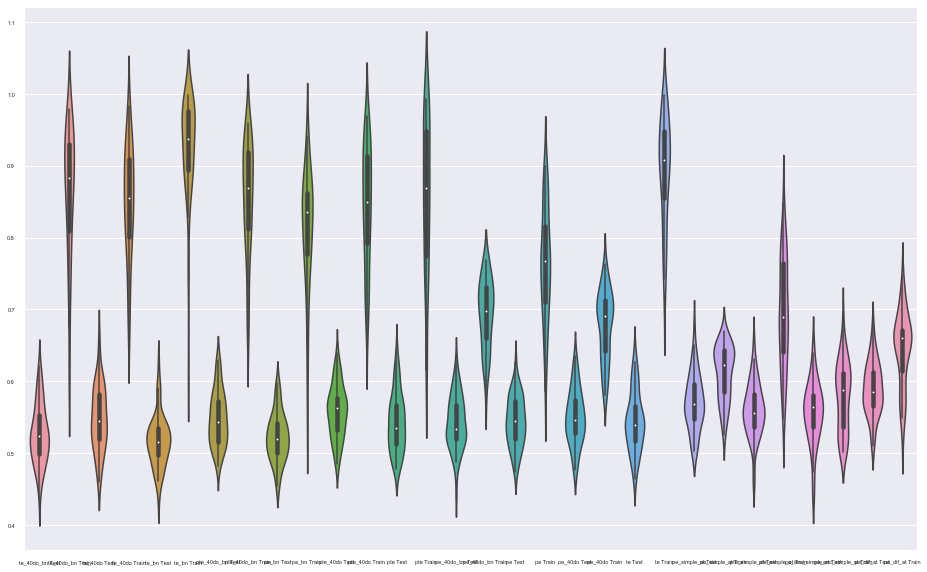

In [11]:
#Plot Accuracy Distributions
acc = pd.read_csv(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/Results/Comparative/acc.csv')
acc = acc.drop(['Unnamed: 0'], axis = 1)
for model in models:
    acc['Test Set Couple'] = list(res[0][model.name].keys())
    acc[str(model.name)+' Test'] = list(res[0][model.name].values())
    acc[str(model.name)+' Train'] = list(res[1][model.name].values())

acc.to_csv(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/Results/Comparative/acc.csv')

plt.figure(figsize = (16,10))
sns.set(font_scale=0.5)
ax = sns.violinplot(data=acc)
plt.savefig(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/Results/Comparative/violinplot.png')

In [12]:
print(acc.mean())
print(acc.std())

te_40do_bn Test           0.526782
te_40do_bn Train          0.864882
te_40do Test              0.547711
te_40do Train             0.852141
te_bn Test                0.517092
te_bn Train               0.924652
pte_40do_bn Test          0.548186
pte_40do_bn Train         0.856384
pe_bn Test                0.522494
pe_bn Train               0.812210
pte_40do Test             0.558059
pte_40do Train            0.844651
pte Test                  0.543310
pte Train                 0.858784
pe_40do_bn Test           0.543145
pe_40do_bn Train          0.695145
pe Test                   0.544330
pe Train                  0.764613
pe_40do Test              0.550571
pe_40do Train             0.678926
te Test                   0.544693
te Train                  0.893990
pe_simple_at Test         0.571389
pe_simple_at Train        0.611560
pte_simple_at Test        0.560389
pte_simple_at Train       0.695081
pe_enc_simple_at Test     0.556776
pe_enc_simple_at Train    0.579169
pe_dif_at Test      

### 5. Accuracy Analysis 

In [56]:
def vocab_representation(couple,k):
    documents_numbers = range(11)
    #Split Training and Test Set
    training_dfs = [dfs[i] for i in (set(documents_numbers)-couple)]
    all_data_train = pd.concat(training_dfs).reset_index()[['Tokenized Utterance']].dropna()
    training_list = np.concatenate(all_data_train['Tokenized Utterance'].values)
    training_vocab = set(training_list) 
    
    test_dfs = [dfs[i] for i in couple]
    all_data_test = pd.concat(test_dfs).reset_index()[['Tokenized Utterance']].dropna()
    test_vocab = set(np.concatenate(all_data_test['Tokenized Utterance'].values))
    test_hist = [list(training_list).count(word) for word in test_vocab]
    mask = np.array(test_hist) > k
    return(len(np.array(test_hist)[mask])/len(test_vocab))   

In [57]:
def vocab_representation_all(k):
    documents_numbers = range(11)
    couples = list(map(set, combinations(documents_numbers, 2)))
    vocab_dic = {}
    for couple in couples:
        print('Processing couple '+str(couple))
        vocab_dic[str(couple)] = vocab_representation(couple,k)
    return(vocab_dic)

In [58]:
k_values = range(0,10,2)
vocab_rep = [vocab_representation_all(k) for k in k_values]

Processing couple {0, 1}


/Users/pablouribepizarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


Processing couple {0, 2}
Processing couple {0, 3}


/Users/pablouribepizarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


Processing couple {0, 4}
Processing couple {0, 5}
Processing couple {0, 6}
Processing couple {0, 7}
Processing couple {0, 8}
Processing couple {0, 9}
Processing couple {0, 10}
Processing couple {1, 2}
Processing couple {1, 3}
Processing couple {1, 4}
Processing couple {1, 5}
Processing couple {1, 6}
Processing couple {1, 7}
Processing couple {8, 1}
Processing couple {1, 9}
Processing couple {1, 10}
Processing couple {2, 3}
Processing couple {2, 4}
Processing couple {2, 5}
Processing couple {2, 6}
Processing couple {2, 7}
Processing couple {8, 2}
Processing couple {9, 2}
Processing couple {2, 10}
Processing couple {3, 4}
Processing couple {3, 5}
Processing couple {3, 6}
Processing couple {3, 7}
Processing couple {8, 3}
Processing couple {9, 3}
Processing couple {10, 3}
Processing couple {4, 5}
Processing couple {4, 6}
Processing couple {4, 7}
Processing couple {8, 4}
Processing couple {9, 4}
Processing couple {10, 4}
Processing couple {5, 6}
Processing couple {5, 7}
Processing couple {8

<Figure size 864x504 with 0 Axes>

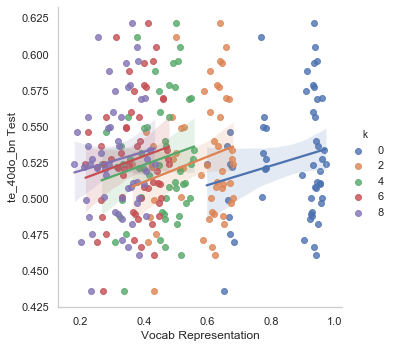

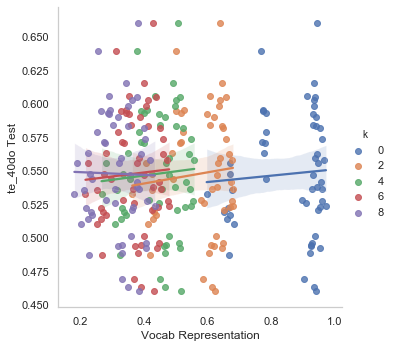

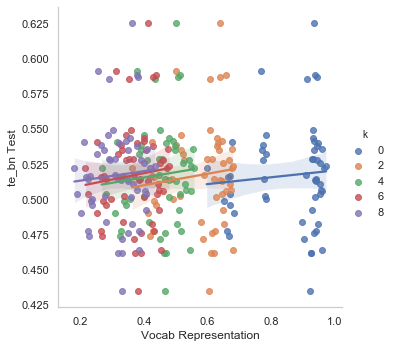

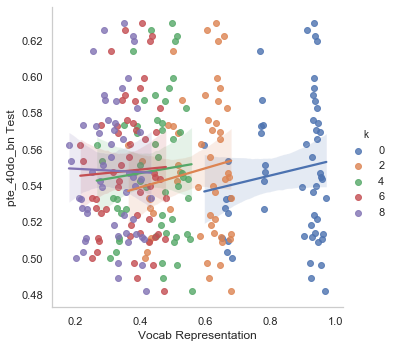

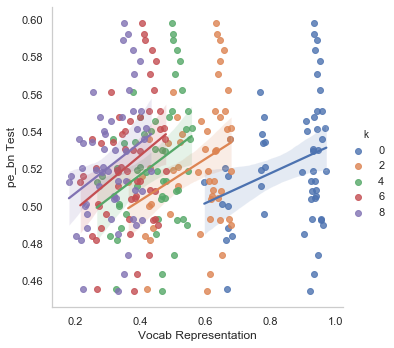

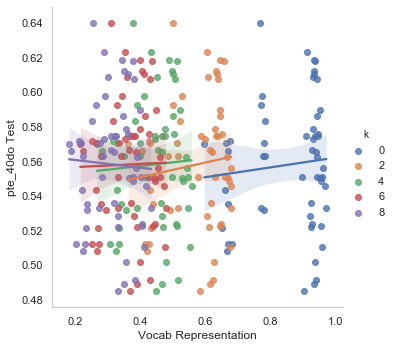

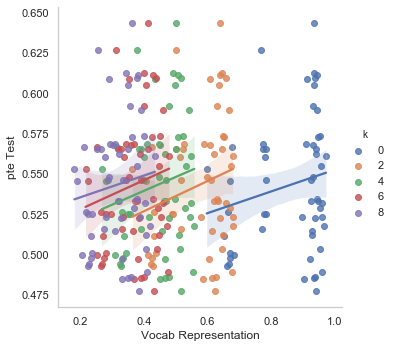

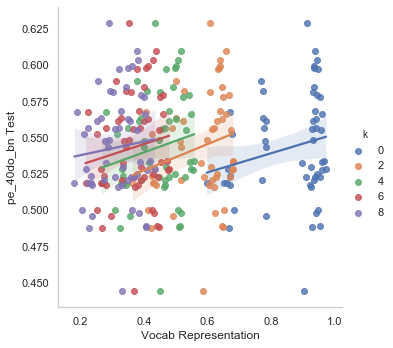

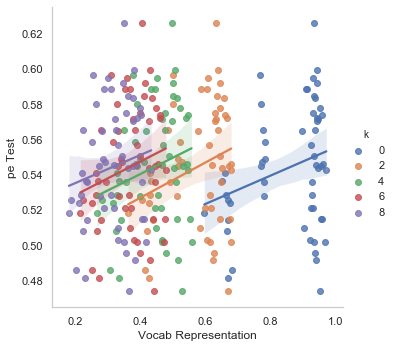

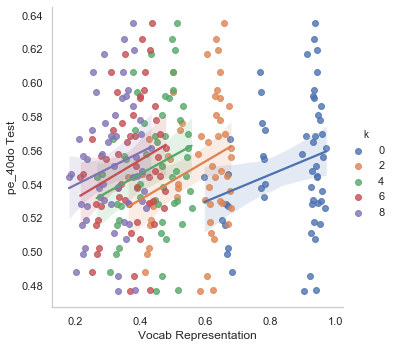

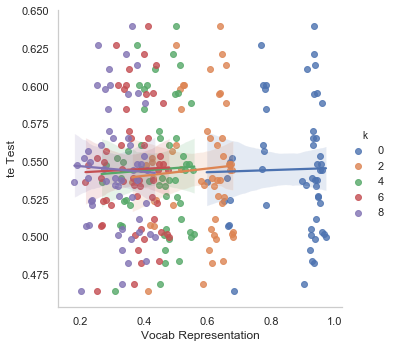

In [97]:
plt.figure(figsize = (12,7))
for model in models:
    acc_model = pd.DataFrame()
    k = 0
    for voc in vocab_rep:
        acc_k = pd.DataFrame()
        acc_k[str(model.name)+' Test'] = acc[str(model.name)+' Test'] = list(res[0][model.name].values())
        acc_k['Vocab Representation'] = voc.values()
        acc_k['k'] = k_values[k]
        acc_model = pd.concat([acc_model,acc_k])
        k = k+1
        
    sns.lmplot(x='Vocab Representation', y=str(model.name)+' Test', hue="k",
               truncate=True, height=5, data=acc_model)
    
    plt.savefig(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/Results/Word_frequency/'+str(model.name)+'.png')

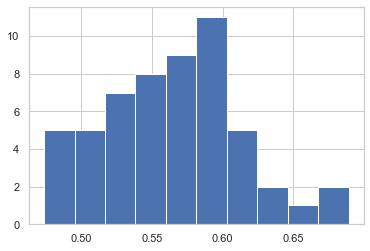

In [53]:
acc['pe_simple_at Test'].hist()

In [85]:
pte_simple_at = pd.DataFrame()
pte_simple_at['Test 1'] = list(res[0]['pe_simple_at'].values())

In [86]:
pte_simple_at.mean()

Test 1    0.573883
dtype: float64

In [13]:
def obtain_confusion_matrix(models):
    documents_numbers = range(11)
    couples = list(map(set, combinations(documents_numbers, 2)))
    max_length = 20
    n_models = len(models)
    dics_test = {}
    dics_train = {}
    for model in models:
        dics_test[model.name] = {}
        dics_train[model.name] = {}
    for couple in couples:
        #Split Training and Test Set
        training_dfs = [dfs[i] for i in (set(documents_numbers)-couple)]
        all_data_train = pd.concat(training_dfs).reset_index()[['Tokenized Utterance','Previous Tokenized Utterance',
                                                                    'Next Tokenized Utterance' ,'Relative Position',
                                                                    'Number of Words','Phase']].dropna()

        X_u_train = pad_sequences(all_data_train['Tokenized Utterance'],maxlen=max_length ,padding='post')
        X_pu_train = pad_sequences(all_data_train['Previous Tokenized Utterance'],maxlen=max_length ,padding='post')
        X_nu_train = pad_sequences(all_data_train['Next Tokenized Utterance'],maxlen=max_length ,padding='post')

        X_r_train = all_data_train['Relative Position']
        X_n_train = all_data_train['Number of Words']

        y_train = keras.utils.to_categorical(all_data_train['Phase'], num_classes=5, dtype='float32')

        test_dfs = [dfs[i] for i in couple]

        all_data_test = pd.concat(test_dfs).reset_index()[['Tokenized Utterance','Previous Tokenized Utterance',
                                                                    'Next Tokenized Utterance' ,'Relative Position',
                                                                    'Number of Words','Phase']].dropna()

        X_u_test = pad_sequences(all_data_test['Tokenized Utterance'],maxlen=max_length ,padding='post')
        X_pu_test = pad_sequences(all_data_test['Previous Tokenized Utterance'],maxlen=max_length ,padding='post')
        X_nu_test = pad_sequences(all_data_test['Next Tokenized Utterance'],maxlen=max_length ,padding='post')

        X_r_test = all_data_test['Relative Position']
        X_n_test = all_data_test['Number of Words']

        y_test = keras.utils.to_categorical(all_data_test['Phase'], num_classes=5, dtype='float32')
    
        for model in models:
            print('Evaluating Model '+str(model.name))
            model.load_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model.name)+'_'+str(list(couple)[0])+str(list(couple)[1])+'.h5')
            
            #Save Accuracy Score: Test
            y_real = y_test.argmax(axis=-1)
            y_pred = model.predict({'p_utterance_input': X_pu_test,
                            'utterance_input': X_u_test,
                            'n_utterance_input': X_nu_test,
                            'rel_position_input': X_r_test,
                            'n_words_input': X_n_test}).argmax(axis=-1)
    
            dics_test[model.name][str(couple)] = confusion_matrix(y_real, y_pred)
            
            #Save Accuracy Score: Train
            y_real = y_train.argmax(axis=-1)
            y_pred = model.predict({'p_utterance_input': X_pu_train,
                            'utterance_input': X_u_train,
                            'n_utterance_input': X_nu_train,
                            'rel_position_input': X_r_train,
                            'n_words_input': X_n_train}).argmax(axis=-1)
        
            dics_train[model.name][str(couple)] = confusion_matrix(y_real, y_pred)
        
    return(dics_test,dics_train)

In [18]:
cm_dif_at = obtain_confusion_matrix(models)

/Users/pablouribepizarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


Evaluating Model pe_dif_at
Evaluating Model pe_dif_at


/Users/pablouribepizarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
E

In [19]:
average_cm = sum([cm/cm.sum() for cm in np.array(list(cm_dif_at[0]['pe_dif_at'].values()))])/len(list(cm_dif_at[0]['pe_dif_at'].values()))

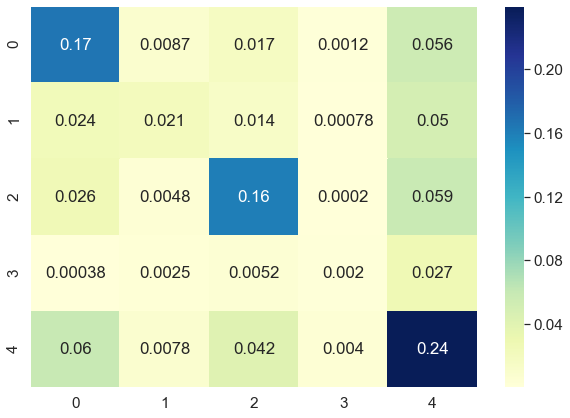

In [20]:
df_cm = pd.DataFrame(average_cm, index = range(5),
                  columns = range(5))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

In [21]:
true_pos = np.diag(average_cm)
false_pos = np.sum(average_cm, axis=0) - true_pos
false_neg = np.sum(average_cm, axis=1) - true_pos

precision = (true_pos / (true_pos + false_pos))

In [22]:
precision

array([0.60108765, 0.47351226, 0.67281633, 0.2428265 , 0.55413045])

In [112]:
df_cm['sum'] = df_cm.astype(float).sum(axis=0)

In [114]:
df_cm

,0,1,2,3,4,sum
0,0.158727,0.008035,0.015362,0.000437,0.066115,0.271830
1,0.023882,0.017153,0.013337,0.000179,0.056411,0.039575
2,0.025377,0.005872,0.154104,0.000000,0.065073,0.226315
3,0.000447,0.002828,0.005240,0.001018,0.027973,0.003827
4,0.063397,0.005687,0.038272,0.002193,0.242881,0.458453


### 6. Data Distribution Analysis:

In [128]:
from scipy.stats import ks_2samp

def ks_test(couple):
    documents_numbers = range(11)
    #Split Training and Test Set
    training_dfs = [dfs[i] for i in (set(documents_numbers)-couple)]
    all_data_train = pd.concat(training_dfs).reset_index()[['Phase']].dropna()
    
    test_dfs = [dfs[i] for i in couple]
    all_data_test = pd.concat(test_dfs).reset_index()[['Phase']].dropna()


    return(ks_2samp(all_data_train['Phase'].values,all_data_test['Phase'].values)[1]) 

In [129]:
def ks_test_all():
    documents_numbers = range(11)
    couples = list(map(set, combinations(documents_numbers, 2)))
    vocab_dic = {}
    for couple in couples:
        print('Processing couple '+str(couple))
        vocab_dic[str(couple)] = ks_test(couple)
    return(vocab_dic)

In [131]:
ks = ks_test_all()

Processing couple {0, 1}
Processing couple {0, 2}
Processing couple {0, 3}
Processing couple {0, 4}
Processing couple {0, 5}


/Users/pablouribepizarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys
/Users/pablouribepizarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


Processing couple {0, 6}
Processing couple {0, 7}
Processing couple {0, 8}
Processing couple {0, 9}
Processing couple {0, 10}
Processing couple {1, 2}
Processing couple {1, 3}
Processing couple {1, 4}
Processing couple {1, 5}
Processing couple {1, 6}
Processing couple {1, 7}
Processing couple {8, 1}
Processing couple {1, 9}
Processing couple {1, 10}
Processing couple {2, 3}
Processing couple {2, 4}
Processing couple {2, 5}
Processing couple {2, 6}
Processing couple {2, 7}
Processing couple {8, 2}
Processing couple {9, 2}
Processing couple {2, 10}
Processing couple {3, 4}
Processing couple {3, 5}
Processing couple {3, 6}
Processing couple {3, 7}
Processing couple {8, 3}
Processing couple {9, 3}
Processing couple {10, 3}
Processing couple {4, 5}
Processing couple {4, 6}
Processing couple {4, 7}
Processing couple {8, 4}
Processing couple {9, 4}
Processing couple {10, 4}
Processing couple {5, 6}
Processing couple {5, 7}
Processing couple {8, 5}
Processing couple {9, 5}
Processing couple {1

In [132]:
acc['Ks p-value'] = list(ks.values())

In [153]:
acc.loc[acc['Ks p-value']>=0.01][['pe_simple_at Test','Ks p-value']].mean()


pe_simple_at Test    0.575550
Ks p-value           0.342532
dtype: float64

In [161]:
acc.loc[acc['Ks p-value']<0.01][['pe_simple_at Test','Ks p-value']].mean()

pe_simple_at Test    0.572023
Ks p-value           0.001656
dtype: float64

In [159]:
acc.loc[acc['Ks p-value']<0.0001][['pe_simple_at Test','Ks p-value']]

,pe_simple_at Test,Ks p-value
1,0.589641,7.926893e-05
3,0.575342,4.382846e-08
6,0.537736,2.550189e-09
7,0.515723,1.041267e-05
14,0.606599,1.764372e-07
23,0.570621,1.925754e-05
28,0.555556,1.727669e-05
30,0.529210,3.271796e-06
36,0.568966,6.363362e-07
40,0.605714,1.379412e-07


In [162]:
acc[['pe_simple_at Test','Ks p-value']].corr()

,pe_simple_at Test,Ks p-value
pe_simple_at Test,1.000000,-0.012468
Ks p-value,-0.012468,1.000000
